<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.856 · Anàlisi de sentiments i xarxes socials</p>
<p style="margin: 0; text-align:right;">Màster universitari de Ciència de Dades (Data Science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

# Anàlisi de sentiments i xarxes socials
## PLA7: Difusió i propagació d'informació

## Introducció

Aquest notebook explora els algorismes de propagació de la informació que es descriuen en el capítol 7 del llibre *Anàlisi de dades de xarxes socials*.

En primer lloc, es presenta el model de cascades independents, implementant una de les versions més esteses d'aquest. Utilitzant com a base la implementació realitzada, s'analitza com els diferents paràmetres de la xarxa afecten la propagació i com podem maximitzar aquesta propagació mitjançant la selecció dels nodes actius inicialment.

En segon lloc, s'implementen els models de dependència global susceptible-infectat (SI), susceptible-infectat-susceptible (SIS) i susceptible-infectat-recuperat (SIR), observant també com els paràmetres dels models afecten el resultat de la propagació.

Recordeu que podeu anar executant els exemples que s'inclouen en els notebooks per a reproduir-los i obtenir-ne els resultats. A més, us animem a modificar el codi dels exemples i executar les vostres modificacions, per anar explorant tot el potencial de les llibreries que es presenten en els notebooks i els algorismes que es detallen.


## 1. Models de dependència local: el model de cascades independents

### 1.1 Model de cascades independents (ICM)

En els models de difusió d'informació basats en dependència local, l'efecte de cada node en la propagació de la informació afecta únicament els seus veïns immediats. Un dels exemples d'aquest tipus de models és el model de cascades independents (ICM). Implementarem la versió bàsica d'aquest model i explorarem com es comporta.

Per a això, utilitzarem la classe per a representar grafs dirigits de networkx, [`Digraph`](https://networkx.github.io/documentation/stable/reference/classes/digraph.html). Definirem un atribut per als nodes del graf, `active`, que contindrà un valor booleà indicant si el node està actiu (`active=True`) o inactiu (`active=False`). Al seu torn, els arcs del graf tindran un atribut prob que ens indicarà la probabilitat que el node d'origen activi el node de destinació. 

Començarem important les llibreries necessàries i creant tres funcions auxiliars que ens serviran per a visualitzar l'execució de l'algorisme:

In [1]:
# importem les libreries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [2]:
# Definim les constants DEBUG, INFO i ERR
DEBUG, INFO, ERR = 0, 1, 2

def print_log(msg, msg_log_level=2, current_log_level=2):
    """
    Mostra un missatge si el nivell de log actual no és més gran que el nivell de log del missatge.
    """
    if current_log_level <= msg_log_level:
        print(msg)
        
        
def perc_of_active_nodes(g):
    """
    Retorna el percentatge de nodes actius atès un graf g.
    """
    return sum(nx.get_node_attributes(g, "active").values()) / len(g.nodes) * 100


def draw_icm(g):
    """
    Mostra una visualització de la xarxa, amb els nodes inactius de color taronja 
    i els nodes actius en vermell.
    """
    # Calculem les posicions 
    pos = nx.kamada_kawai_layout(g)
    # Mostrem les arestes
    nx.draw_networkx_edges(g, pos=pos)
    # Mostrem tots els nodes en color taronja
    nx.draw_networkx_nodes(g, pos=pos, node_color='#ff6600')
    # Repintem els nodes que volem destacar de color vermell
    act = [n[0] for n in g.nodes(data=True) if n[1]["active"]]
    nx.draw_networkx_nodes(g, pos=pos, nodelist=act, node_color='#cc0000')
    # Mostrem les etiquetes
    nx.draw_networkx_labels(g, pos=pos)
    

Pel que fa a l'algorisme de cascades independents, implementarem tres funcions, `init_activation`, `init_affect_probs` i `icm`. La funció `init_activation` seleccionarà els nodes que es troben actius en iniciar l'algorisme, segons la probabilitat que un node estigui actiu en el moment inicial t=0. La funció `init_affect_probs` inicialitzarà les probabilitats que un node afecti un altre node. Per a simplificar la implementació, aquestes probabilitats seran constants, encara que podríem fixar-ne una altra distribució. Finalment, la funció `icm` implementarà l'algorisme de cascades independents: a cada iteració, se seleccionaran aleatòriament els nodes que s'activen, sobre la base dels quals s'hagin activat en la iteració anterior i de les probabilitats descrites en els arcs.

In [3]:
def init_activation(g, prob=0.1):
    """
    Selecciona els nodes que es troben actius en t=0 aleatòriament. Cada node
        estarà actiu amb probabilitat prob.
    """
    act = {n: np.random.choice([True, False], p=[prob, 1-prob]) for n in g.nodes()}
    nx.set_node_attributes(g, act, "active")
    return g

def init_affect_probs(g, prob=0.3):
    """
    Assigna les probabilitats que un node d'origen afecti un node de destinació. En aquest cas
        les probabilitats són constants per a tots els arcs del graf.
    """
    nx.set_edge_attributes(g, {e: prob for e in g.edges()}, 'prob')
    return g

def icm(g):
    """
    Implementa l'algorisme icm.
    """
    # Recuperem els nodes actius en t=0
    activated_last_it = [n[0] for n in g.nodes(data=True) if n[1]["active"]]
    # Recuperem les probabilitats que un node d'origen afecti un node de destinació
    edge_probs = nx.get_edge_attributes(g, 'prob')
    
    evolution = []
    t = 1
    while len(activated_last_it) != 0:
        evolution.append(g.copy())
        print_log("[t={}] Activated in previous iteration: {}".format(t, activated_last_it), INFO, CURRENT_LOG_LEVEL)
        print_log("[t={}] Percentage of active nodes: {}%".format(t, perc_of_active_nodes(g)), INFO, CURRENT_LOG_LEVEL)
        activated_this_it = []
        # Per a cada node activat en la iteració anterior, decidim si s'activen els seus successors:
        for node in activated_last_it:
            for neigh in g.successors(node):
                print_log("\tDealing with source {} destination {}".format(node, neigh), DEBUG, CURRENT_LOG_LEVEL)
                # Només es pot activar un node que actualment estigui inactiu
                if not g.nodes(data=True)[neigh]["active"]:
                    # Es decideix aleatòriament si s'activa el veí en funció de la probabilitat de l'arc
                    prob = edge_probs[(node, neigh)]
                    activate_now = np.random.choice([True, False], p=[prob, 1-prob])
                    if activate_now:
                        print_log("\t\t{} is not active and will activate".format(neigh), DEBUG, CURRENT_LOG_LEVEL)
                        activated_this_it.append(neigh)
                        nx.set_node_attributes(g, {neigh: True}, "active")
        activated_last_it = activated_this_it
        t += 1
    
    # Retornem una llista amb l'evolució de l'algorisme en cada iteració.
    return evolution

Executem, doncs, l'algorisme icm per a un graf generat aleatòriament:

In [4]:
# Seleccionem el nivell màxim de log
CURRENT_LOG_LEVEL = DEBUG
# Fixem la llavor d'aleatorietat
np.random.seed(1)

# Generem un graf dirigit aleatori amb 10 nodes
g = nx.erdos_renyi_graph(n=10, p=0.5, seed=1, directed=True)
# Seleccionem els nodes actius inicialment (cada node s'activarà en t=0 amb probabilitat 0.1)
g = init_activation(g, prob=0.1)
# Fixem la probabilitat d'activar un veí a 0.3
g = init_affect_probs(g, prob=0.3)

# Executem l'algorisme
evolution = icm(g)

[t=1] Activated in previous iteration: [2, 5]
[t=1] Percentage of active nodes: 20.0%
	Dealing with source 2 destination 1
	Dealing with source 2 destination 3
	Dealing with source 2 destination 6
		6 is not active and will activate
	Dealing with source 2 destination 7
	Dealing with source 2 destination 8
		8 is not active and will activate
	Dealing with source 2 destination 9
	Dealing with source 5 destination 2
	Dealing with source 5 destination 6
[t=2] Activated in previous iteration: [6, 8]
[t=2] Percentage of active nodes: 40.0%
	Dealing with source 6 destination 2
	Dealing with source 6 destination 3
	Dealing with source 6 destination 5
	Dealing with source 6 destination 7
	Dealing with source 8 destination 0
		0 is not active and will activate
	Dealing with source 8 destination 4
		4 is not active and will activate
	Dealing with source 8 destination 5
[t=3] Activated in previous iteration: [0, 4]
[t=3] Percentage of active nodes: 60.0%
	Dealing with source 0 destination 1
	Deali

Inicialment (en t=0) els nodes 2 i 5 estan actius. En t=1, d'entre els successors del node 2 (que són els nodes 1, 3, 6, 7, 8 i 9), s'activen els nodes 6 i 8. Els successors del node 5 (que són el 2 i 6) ja estan actius. En t=2 es decideix quins dels successors dels nodes 6 i 8 s'activen (s'activen el 0 i el 4). Finalment, en t=3 es decideix quins dels successors dels nodes 0 i 4 s'activen. Atès que cap d'ells no ho fa, l'execució de l'algorisme acaba amb el 60% dels nodes activats.

Podem utilitzar la funció `draw_icm` per a visualitzar gràficament l'execució de l'algorisme:

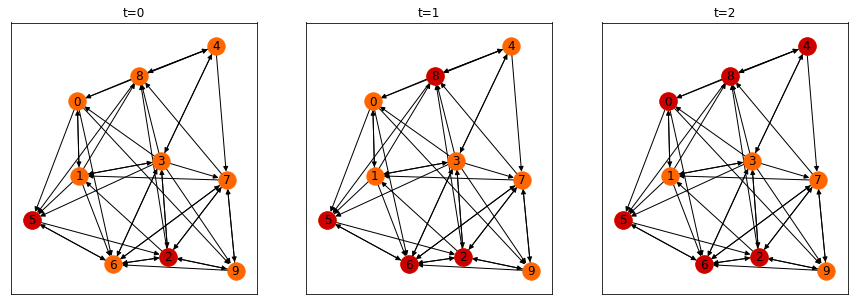

In [5]:
# Generem una figura amb 3 subfigures (columnes) i tantes files com sigui necessari
num_rows = ceil(len(evolution)/3)
plt.figure(num=None, figsize=(15, 5*num_rows))
for i, e in enumerate(evolution):
    ax = plt.subplot(num_rows, 3, i+1)
    ax.set_title("t={}".format(i))
    draw_icm(e)

### 1.2 Efectes dels paràmetres de xarxa sobre el nombre de nodes activats

És interessant observar que l'execució anterior de l'algorisme ha finalitzat amb només un 60% dels nodes actius. Atès que l'algorisme és probabilístic, ens podríem preguntar si aquest resultat és habitual per a una xarxa de les característiques que hem utilitzat. Per a analitzar-ho, generarem diverses xarxes similars (utilitzant el mateix model, amb el mateix nombre de nodes i d'arcs) i executarem l'algorisme amb els mateixos paràmetres (la mateixa probabilitat d'activació d'un node en l'estat inicial i que un node activi un dels seus successors):

In [6]:
# Abaixem el nivell de log per a visualitzar únicament els missatges d'error
CURRENT_LOG_LEVEL = ERR

# Creem una funció que rep com a paràmetres la configuració de xarxa i les probabilitats d’usar-la en icm
def ending_active(num_nodes=10, er_prob=0.5, init_activ_prob=0.1, init_affect_prob=0.3, num_its=300):
    perc_activated = []
    for _ in range(num_its):
        g = nx.erdos_renyi_graph(n=num_nodes, p=er_prob, directed=True)
        g = init_activation(g, prob=init_activ_prob)
        g = init_affect_probs(g, prob=init_affect_prob)
        evolution = icm(g)
        # Desem el percentatge de nodes actius en finalitzar l'execució
        if len(evolution):
            perc_activated.append(perc_of_active_nodes(evolution[-1]))
        else:
            perc_activated.append(0)
    return np.mean(perc_activated)

In [7]:
# Calculem la mitjana del percentatge de nodes actius al final de l'execució de l'algorisme
ending_active()

34.56666666666667

Així, doncs, la mitjana dels nodes actius al final de l'execució és bastant inferior al valor que hem obtingut en la primera execució de l'algorisme. 
D'altra banda, podem usar la funció `ending_active` que hem definit per observar com els paràmetres de xarxa afecten el resultat de l'execució de l'algorisme. Per exemple, podem veure com evoluciona el percentatge de nodes actius al final de l'execució en variar la densitat de la xarxa:

<u>Nota</u>: l'execució del bloc de codi següent pot trigar uns minuts. Si voleu reduir el temps d'execució, podeu rebaixar la resolució de la gràfica, disminuint el tercer paràmetre de la trucada a `arange`.

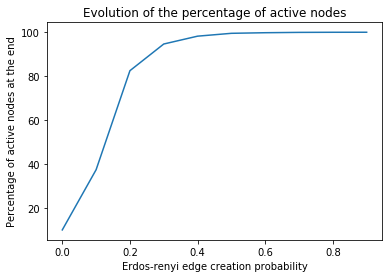

In [8]:
# Variem la probabilitat de connexió d'una aresta del model erdos-renyi de 0 a 1, amb pas 0.01
xs = np.arange(0, 1, 0.1)
# Calculem el nombre mitjà de nodes activats al final de l'execució per a cada valor de x
ys = [ending_active(num_nodes=100, er_prob=x, init_affect_prob=0.1) for x in xs]

# Mostrem  una gràfica amb el resultat
plt.figure()
plt.plot(xs, ys)
plt.title("Evolution of the percentage of active nodes")
plt.xlabel("Erdos-renyi edge creation probability")
_ = plt.ylabel("Percentage of active nodes at the end")

Podeu provar també a canviar altres paràmetres de l'execució de l'algorisme, per veure com afecten el percentatge final de nodes actius:

In [9]:
ending_active(num_nodes=100, er_prob=0.2, init_activ_prob=0.1, init_affect_prob=0.5, num_its=300)

99.99333333333334

### 1.3 Maximització de la propagació

En l'apartat anterior hem vist com varia el conjunt de nodes actius al final de l'execució en modificar la topologia de la xarxa de connexions. De totes maneres, en molts dels problemes reals en els quals podríem aplicar aquests models, les xarxes ja existeixen (ja estan creades) i és difícil modificar-les per a aconseguir els nostres propòsits. En canvi, de vegades podrem influir en quins són els nodes actius al principi de l'execució. En aquest context, té sentit plantejar-se quins nodes volem activar al principi, per intentar maximitzar el conjunt de nodes actius en finalitzar l'execució. Això tindria sentit, per exemple, en el context d'una campanya publicitària, on podríem promocionar un producte (potser fins i tot regalar-ne mostres) a un conjunt petit d'usuaris, amb l'objectiu que en parlin bé, intentant maximitzar el nombre d'usuaris que acaben sentint parlar del producte anunciat.

Implementarem l'estratègia *greedy* de maximització de la propagació de l'algorisme de cascades independents. Per a això, implementarem dues funcions: la funció `evaluate_candidate` permetrà avaluar la contribució a la propagació d'un node concret atès l'estat actual de la xarxa; la funció `greedy_max` seleccionarà els *k* nodes que s’han d’activar inicialment, seleccionant el millor candidat en cada moment (segons els resultats de `evaluate_candidate`).

In [10]:
def evaluate_candidate(g, candidate, num_its=20):
    """
    Retorna la mitjana de nodes activats pel node candidate en num_its iteracions.
    """
    edge_probs = nx.get_edge_attributes(g, 'prob')
    num_nodes_activated = []
    for _ in range(num_its):
        activated_this_it = 0
        # Per a cada successor del candidat, provem si s'activa considerant les probabilitats dels arcs
        for neigh in g.successors(candidate):
            if not g.nodes(data=True)[neigh]["active"]:
                prob = edge_probs[(candidate, neigh)]
                activate_now = np.random.choice([True, False], p=[prob, 1-prob])
                if activate_now:
                    activated_this_it += 1
        # Desem el nombre de nodes que activa el candidat cada vegada que repetim la prova
        num_nodes_activated.append(activated_this_it)
    # Retornem la mitjana del nombre de nodes activats
    return np.mean(num_nodes_activated)


def greedy_max(g, k):
    """
    Selecciona els `k` nodes que maximitzen la propagació seguint una estratègia `greedy`.
    """
    initial_activation = []
    # A cada iteració del bucle, se selecciona el millor candidat atès l'estat actual de la xarxa
    for _ in range(k):
        # Tots els nodes inactius són candidats a activar-se
        candidates = [n[0] for n in g.nodes(data=True) if not n[1]["active"]]
        best_candidate, best_num_activations = -1, 0
        for candidate in candidates:
            # Desem el millor candidat, segons el resultat de `evaluate_candidate`
            num_activations = evaluate_candidate(g, candidate)
            if num_activations >= best_num_activations:
                best_candidate = candidate
                best_num_activations = num_activations
        nx.set_node_attributes(g, {best_candidate: True}, "active")
        initial_activation.append(best_candidate)
        
    return g, initial_activation        

Per provar l'algorisme, generarem una xarxa amb 50 nodes, seleccionarem 3 nodes inicials utilitzant, d'una banda, l'estratègia *greedy* que acabem d'implementar i, d'altra banda, fent una selecció aleatòria, i visualitzarem el graf resultant d'aplicar l'algorisme `icm` amb ambdues inicialitzacions:

Greedy selects as initial active nodes: [21, 34, 31]
Random selects as initial active nodes: [6, 29, 4]


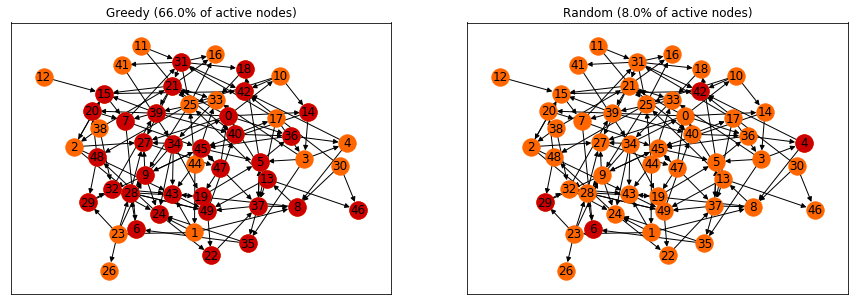

In [11]:
# Seleccionem el nivell de log ERR
CURRENT_LOG_LEVEL = ERR
np.random.seed(1)

# Fixem en 3 el nombre de nodes actius a l'inici
num_k = 3

# Generem un graf dirigit aleatori amb 50 nodes
g = nx.erdos_renyi_graph(n=50, p=0.05, seed=1, directed=True)
# Fixem la probabilitat d'activar un veí a 0,3 
g = init_affect_probs(g, prob=0.5)
# Inicialitzem els atributs active dels nodes (fixant-los tots a False)
g = init_activation(g, prob=0)

# Seleccionem els nodes inicials amb l'algorisme de maximització de la propagació
g_greedy, initial_activation_gr = greedy_max(g.copy(), k=num_k)
# Seleccionem els nodes inicials aleatòriament
g_random, initial_activation_rand = g.copy(), list(np.random.choice(g.nodes(), num_k))
nx.set_node_attributes(g_random, {n: True for n in initial_activation_rand}, "active")

# Executem l'algorisme icm amb totes dues inicialitzacions
evolution_greedy = icm(g_greedy)
evolution_random = icm(g_random)

# Visualitzem el resultat
plt.figure(num=None, figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
print("Greedy selects as initial active nodes: {}".format(initial_activation_gr))
ax.set_title("Greedy ({}% of active nodes)".format(perc_of_active_nodes(evolution_greedy[-1])))
draw_icm(evolution_greedy[-1])
           
ax = plt.subplot(1, 2, 2)
print("Random selects as initial active nodes: {}".format(initial_activation_rand))
ax.set_title("Random ({}% of active nodes)".format(perc_of_active_nodes(evolution_random[-1])))
draw_icm(evolution_random[-1])

En aquest cas, l'algorisme *greedy* aconsegueix millorar la propagació de la informació enfront d'una selecció aleatòria. De totes maneres, si proveu de variar la llavor d’aleatorietat (per exemple, comentant la línia `np.random.seed(1)`), veureu que això no sempre és així: les característiques del graf juntament amb el fet que l'algorisme *greedy* seleccioni el millor candidat en cada moment sense tenir en compte les conseqüències a llarg termini d'aquesta selecció, fan que el resultat no sempre sigui òptim.

## 2. Models de dependència global

A diferència dels models de dependència local, en els models de dependència global la decisió d'activació (o infecció) d'un individu no depèn dels seus veïns directes a la xarxa. Implementarem els tres models de propagació d'epidèmies que es descriuen en el capítol 7 del llibre *Análisis de datos de redes sociales*, per observar com es comporten segons els paràmetres que es consideren. En aquests models, les connexions concretes de la xarxa seran desconegudes, però sabrem quin és el grau mitjà dels nodes, *k*.

### 2.1 Model susceptible-infectat (SI)

En el model susceptible-infectat, els individus només poden estar en dos estats (susceptible o infectat) i, una vegada infectats, ja no poden tornar a canviar d'estat. El paràmetre $\beta$ determina la probabilitat d'infecció quan hi ha contacte entre individus.

In [12]:
from math import e, pow

def model_si(i_0, beta, k, t):
    """
    Calculem la fracció d'individus infectats en l'instant t segons el model SI.
    """
    return i_0*pow(e, beta*k*t)/(1+i_0*(pow(e, beta*k*t)-1))

Utilitzarem la funció `model_si` que acabem de definir per a veure com evolucionen la fracció d'individus infectats i susceptibles en el temps, per a una xarxa amb grau mitjà 4, començant amb un 1% dels nodes infectats i amb $\beta=0.03$.

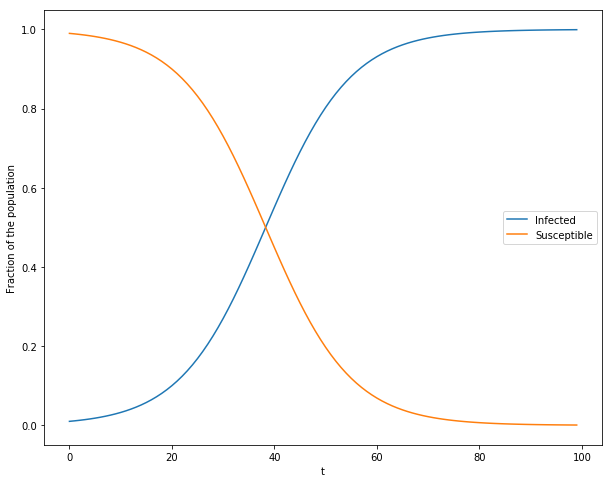

In [13]:
# Calculem la fracció d'individus infectats per a t en [0, 100)
i_0, k, beta = 1/100, 4, 0.03
ts = np.arange(0, 100, 1)
it = [model_si(i_0, beta, k, t) for t in ts]

# Mostrem  gràficament el resultat
plt.figure(num=None, figsize=(10, 8))
plt.plot(ts, it)
plt.plot(ts, [1-i for i in it])
plt.legend(["Infected", "Susceptible"])
plt.xlabel("t")
_ = plt.ylabel("Fraction of the population")

Podem observar com, a causa que els individus no es poden recuperar, a mesura que passa el temps cada vegada hi ha més individus infectats, fins que ho està tota la població.

També podem utilitzar la funció `model_si` per a veure com es comporta el model per a diferents valors de *k* (el grau mitjà de la xarxa):

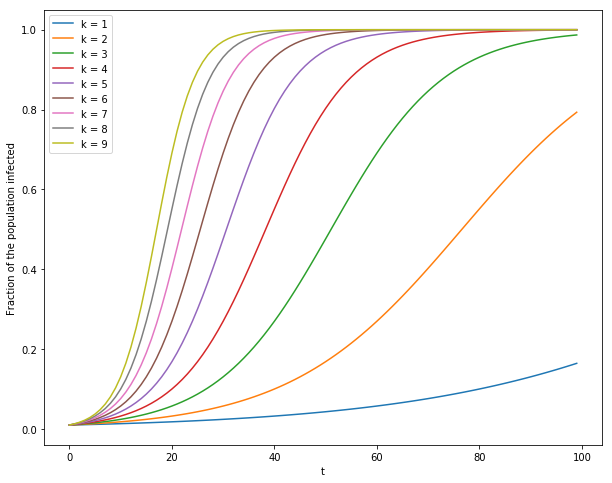

In [14]:
plt.figure(num=None, figsize=(10, 8))

# Calculem la fracció d'infectats en el temps per a diferents valors de `k`
i_0, beta = 1/100, 0.03
ts, ks, l = range(0, 100), range(1, 10), []
for k in ks:
    it = [model_si(i_0, beta, k, t) for t in ts]
    plt.plot(ts, it)
    l.append("k = {}".format(k))
    
plt.legend(l)
plt.xlabel("t")
_= plt.ylabel("Fraction of the population infected")

Així, doncs, en augmentar el grau mitjà de la xarxa, s'afavoreix la infecció (ja que els individus tenen més contactes). Per exemple, en *t=20*, solament un 1,8% dels individus estan infectats per a *k=1*, mentre que el percentatge arriba al 69,1% per a *k=9*.

### 2.2 Model susceptible-infectat-susceptible (SIS)

En el model susceptible-infectat-susceptible, els individus també poden estar únicament en dos estats, susceptible o infectat, però ara poden tornar a l'estat susceptible després d'haver estat infectats. 

In [15]:
def model_sis(i_0, beta, mu, k, t):
    """
    Calculem la fracció d'individus infectats en l'instant t segons el model SIS.
    """    
    c = i_0/(1-i_0-mu/(beta*k))
    return (1-mu/(beta*k))*c*pow(e, (beta*k-mu)*t)/(1+c*(pow(e, (beta*k-mu)*t)))

Utilitzem la funció `model_sis` que acabem de definir per a veure com evolucionen la fracció d'individus infectats, per a una xarxa amb grau mitjà 4, començant amb un 1% dels nodes infectats, amb una probabilitat d'infecció β=0,05, i variant la probabilitat de recuperació $\mu$:

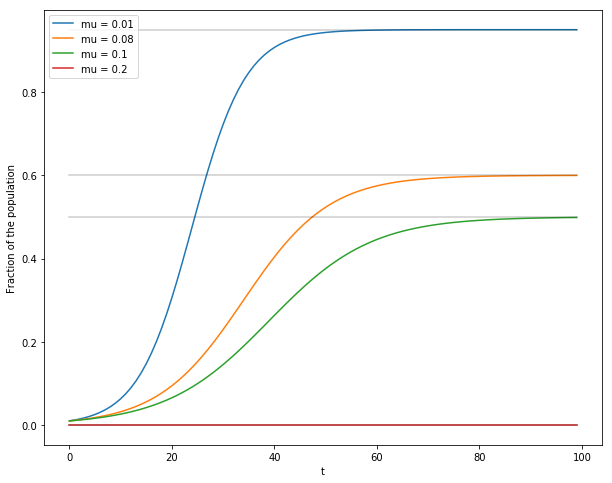

In [16]:
# Calculem la fracció d'infectats en el temps per a diferents valors de mu
mus = [0.01, 0.08, 0.1, 0.2]
i_0, k, beta = 1/100, 4, 0.05
plt.figure(num=None, figsize=(10, 8))
ts = np.arange(0, 100, 1)
l, i_infs = [], []
for mu in mus:
    # Calculem la fracció d'individus infectats en funció de t
    it = [model_sis(i_0, beta, mu, k, t) for t in ts]
    # Calculem la fracció d'individus infectats quan t tendeix a infinit
    i_inf = 1 - mu/(beta*k)
    plt.plot(ts, it)
    i_infs.append(i_inf)
    l.append("mu = {}".format(mu))
    
plt.legend(l)
plt.xlabel("t")
_ = plt.ylabel("Fraction of the population")

# Mostrem el valor de la fracció d'infectats quan t tendeix a infinit com una
# línia grisa
for i_inf in i_infs:
    plt.plot(ts, [i_inf for _ in ts], alpha=0.2, color='k')

Podem veure com, per a una mateixa probabilitat d'infecció $\beta=0.05$, com més alta és la probabilitat de recuperació $\mu$ menys individus estan infectats en cada moment de temps (i més lent és el creixement de la fracció d'infectats).

### 2.3 Model susceptible-infectat-recuperat (SIR)

Finalment, implementarem el model susceptible-infectat-recuperat, en el qual els individus, a més de poder estar en estat susceptible i infectat, també poden trobar-se en estat recuperat. Un individu recuperat ja no es pot tornar a infectar:

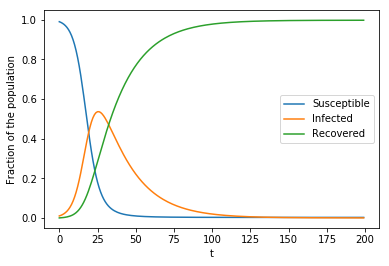

In [17]:
from scipy.integrate import odeint

# Fixem la fracció inicial d'infectats a 0,01 (1%) i la de recuperats a 0 (la resta són susceptibles)
i_0, r_0 = 1/100, 0
s_0 = 1 - i_0 - r_0
# Fixem la probabilitat d'infecció i de recuperació
beta, mu = 0.3, 0.05
# Avaluarem la funció en l'interval t = [0, 200)
t = range(0, 200)

# Definim les equacions diferencials
def deriv(y, t, beta, mu):
    s, i, r = y
    dsdt = - beta*s*i 
    didt = beta*s*i - mu*i
    drdt = mu*i
    return dsdt, didt, drdt

# Definim els paràmetres inicials
y0 = s_0, i_0, r_0
# Definim la funció model_sir, que calcula la fracció de susceptibles, infectats i recuperats en 
# funció del temps
model_sir = lambda t: odeint(deriv, y0, t, args=(beta, mu)).T
# Calculem la fracció de susceptibles, infectats i recuperats per a t = [0, 200)
s, i, r = model_sir(t)

# Mostrem el resultat
fig = plt.figure()
plt.plot(t, s, t, i, t, r)
plt.xlabel("t")
plt.ylabel("Fraction of the population")
_ = plt.legend(["Susceptible", "Infected", "Recovered"])

Variant els paràmetres $\beta$ i $\mu$, podem veure quins efectes tenen les probabilitats d'infecció i recuperació sobre el resultat final de la població.